#1. Install neccessary libraries

In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentation

#2. Download Dataset

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

In [ ]:
!tar -xf annotations.tar.gz
!tar -xf images.tar.gz

#3. Load libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 #np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

#4. Visualiation

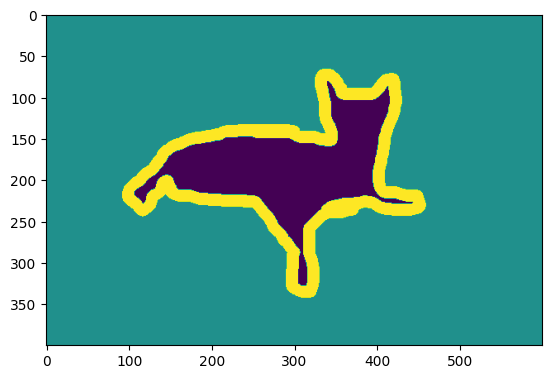

In [ ]:
mask_path = '/content/annotations/trimaps/Abyssinian_1.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)

In [ ]:
print(np.unique(mask))

[1 2 3]


(400, 600, 3)


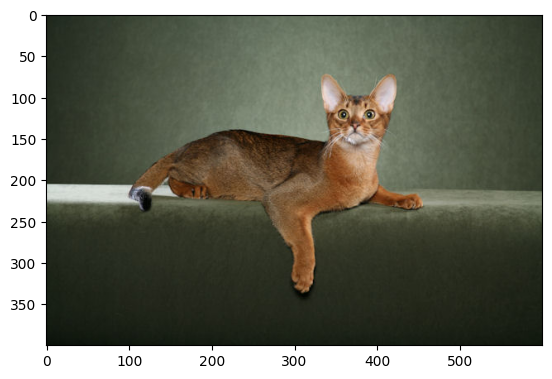

In [ ]:
image_path = '/content/images/Abyssinian_1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print(image.shape)

#5. Preprocess data

In [ ]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, txt_file, transform=None): #transform: augmentation + norm + np.array -> torch.tensor
    super().__init__()
    self.root_dir = root_dir
    self.txt_file = txt_file
    self.transform = transform
    self.img_path_lst = []
    with open(self.txt_file) as file_in:
      for line in file_in:
        self.img_path_lst.append(line.split(' ')[0])

  def __len__(self):
    return len(self.img_path_lst)

  def __getitem__(self, idx):
    image_path = os.path.join(self.root_dir, "images", "{}.jpg".format(self.img_path_lst[idx]))
    mask_path = os.path.join(self.root_dir, "annotations", "trimaps", "{}.png".format(self.img_path_lst[idx]))
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #foreground -> 1
    #background 2 -> 0
    #Not classified 3 -> 1
    mask[mask == 2] = 0
    mask[mask == 3] = 1
    #image (RGB), mask (2D matrix)
    if self.transform is not None:
      transformed = self.transform(image=image, mask=mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']
    return transformed_image, transformed_mask

In [ ]:
train_size = 384

train_transform = A.Compose([
    A.Resize(width=train_size, height=train_size),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.00),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=train_size, height=train_size),
    A.Normalize(),
    ToTensorV2() #np.array -> torch.tensor (B, 3, H, W)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
class UnNormalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    """
    Args:
      tensor (Tensor): Tensor image of size (C, H, W) to be normalized'
    Returns:
      Tensor: Normalized image
    """
    for t, m, s in zip(tensor, self.mean, self.std):
      t.mul_(s).add_(m)
      #The normalize code -> t.sub_(m).div_(s)
    return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

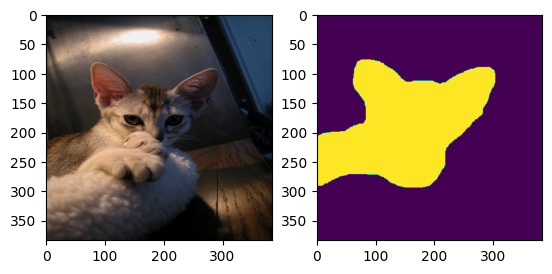

In [ ]:
train_dataset = DogCatDataset("/content", "/content/annotations/trainval.txt", transform=train_transform)
test_dataset = DogCatDataset("/content", "/content/annotations/trainval.txt", transform=test_transform)
image, mask = train_dataset.__getitem__(10)
# print(image.shape, mask.shape)
# print(mask.unique())
plt.subplot(1,2,1)
plt.imshow(unorm(image).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask)


#6. Create Model để training

In [ ]:
#model Unet
def unet_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, 1, 1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, 3,1,1),
      nn.ReLU()
  )

class UNet(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.downsample = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
    self.block_down1 = unet_block(3, 64)
    self.block_down2 = unet_block(64, 128)
    self.block_down3 = unet_block(128, 256)
    self.block_down4 = unet_block(256, 512)
    self.block_neck = unet_block(512, 1024)
    self.block_up1 = unet_block(1024+512, 512)
    self.block_up2 = unet_block(512+256, 256)
    self.block_up3 = unet_block(256+128, 128)
    self.block_up4 = unet_block(128+64, 64)
    self.conv_cls = nn.Conv2d(64, self.n_classes, 1) # -> (B, n_class, H, W)


  def forward(self, x):
    x1 = self.block_down1(x)
    x = self.downsample(x1)
    x2 = self.block_down2(x)
    x = self.downsample(x2)
    x3 = self.block_down3(x)
    x = self.downsample(x3)
    x4 = self.block_down4(x)
    x = self.downsample(x4)

    x = self.block_neck(x)

# (B, 1024, H, W) cat (B, 512, H, W) -> (B, 1024+512. H, W)

    x = torch.cat([x4, self.upsample(x)], dim=1)
    x = self.block_up1(x)
    x = torch.cat([x3, self.upsample(x)], dim=1)
    x = self.block_up2(x)
    x = torch.cat([x2, self.upsample(x)], dim=1)
    x = self.block_up3(x)
    x = torch.cat([x1, self.upsample(x)], dim=1)
    x = self.block_up4(x)
    x = self.conv_cls(x)
    return x

# model = UNet(1)
# x = torch.rand(4, 3, train_size, train_size)
# print(x.shape)
# y = model(x)
# print(y.shape)

# y true (4, 384, 384)
# y hat (4, 1, 384, 384) --> squeeze()

In [ ]:
class AverageMeter(object):
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
def accuracy_function(preds, targets):
  preds_flat = preds.flatten()
  targets_flat = targets.flatten()
  acc = torch.sum(preds_flat == targets_flat)
  return acc/targets_flat.shape[0]

In [ ]:
  # device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 8
n_workers = os.cpu_count()
print("num_workers = ", n_workers)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

# model
model = UNet(1).to(device)

# loss
criterion = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 30

# metrics
dice_fn = Dice(num_classes=2, average="macro").to(device)
iou_fn = JaccardIndex(num_classes=2, task="binary", average="macro", ).to(device)

# meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

cuda
num_workers =  2


In [ ]:
for ep in range(1, 1 + n_eps):
  acc_meter.reset()
  train_loss_meter.reset()
  dice_meter.reset()
  iou_meter.reset()
  model.train()

  for batch_id, (x,y) in enumerate(tqdm(trainloader), start=1):
    optimizer.zero_grad()
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).float()
    y_hat = model(x)
    y_hat = y_hat.squeeze()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      y_hat_mask = y_hat.sigmoid().round().long() # -> mask (0,1)
      dice_score = dice_fn(y_hat_mask, y.long())
      iou_score = iou_fn(y_hat_mask, y.long())
      accuracy = accuracy_function(y_hat_mask, y.long())

      train_loss_meter.update(loss.item(), n)
      iou_meter.update(iou_score.item(), n)
      dice_meter.update(dice_score.item(), n)
      acc_meter.update(accuracy.item(), n)
  print(("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
      ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
  )))
  if ep >= 25:
    torch.save(model.state_dict(), "/content/model_ep_{}.pth".format(ep))

100%|██████████| 460/460 [08:09<00:00,  1.07s/it]


EP 1, train loss = 0.5644087075539257, accuracy = 0.7058884662778481, IoU = 0.4045614668864647, dice = 0.6511234211532966


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 2, train loss = 0.5096001441711965, accuracy = 0.7621343093073887, IoU = 0.5388096972004227, dice = 0.7499690331842588


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 3, train loss = 0.46869434319112613, accuracy = 0.7872964564872824, IoU = 0.5860515864646954, dice = 0.7778824918943903


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 4, train loss = 0.4196783809558205, accuracy = 0.8126630652209986, IoU = 0.6278851735851039, dice = 0.8046398954546969


100%|██████████| 460/460 [08:07<00:00,  1.06s/it]


EP 5, train loss = 0.3907092048098212, accuracy = 0.8279141572506531, IoU = 0.6527588465939398, dice = 0.8202387264241343


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 6, train loss = 0.36543090949239937, accuracy = 0.8411782884079477, IoU = 0.6758132660518522, dice = 0.834176864053892


100%|██████████| 460/460 [08:07<00:00,  1.06s/it]


EP 7, train loss = 0.33861980451189955, accuracy = 0.8543113674806512, IoU = 0.6984932368864184, dice = 0.8477193845354992


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 8, train loss = 0.32204245584814445, accuracy = 0.8623254339332166, IoU = 0.7136793734586757, dice = 0.8562990048657293


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 9, train loss = 0.3028626983580382, accuracy = 0.8714455684889918, IoU = 0.7299509789632714, dice = 0.8657110295865846


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 10, train loss = 0.28987316881184994, accuracy = 0.8782867083083028, IoU = 0.7432868520850721, dice = 0.8730501655651175


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 11, train loss = 0.2807478899541109, accuracy = 0.8820690651302753, IoU = 0.7496994998144066, dice = 0.876909687726394


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 12, train loss = 0.272444708418587, accuracy = 0.8867424249649047, IoU = 0.758346409642178, dice = 0.8817056556110797


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 13, train loss = 0.2619579211687264, accuracy = 0.8906361688738283, IoU = 0.7660646086153777, dice = 0.8858538717031479


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 14, train loss = 0.25314064366014105, accuracy = 0.8954136922307636, IoU = 0.77441363023675, dice = 0.8906691369803056


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 15, train loss = 0.24484733069396536, accuracy = 0.8985229369090951, IoU = 0.7812870346981546, dice = 0.8940885389628618


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 16, train loss = 0.24131202446701733, accuracy = 0.9003647692825483, IoU = 0.7844678569099177, dice = 0.8956984891839649


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 17, train loss = 0.23288655447895112, accuracy = 0.9039348192836927, IoU = 0.7909948485053104, dice = 0.8996531548707382


100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


EP 18, train loss = 0.22351785000899563, accuracy = 0.9086023306069166, IoU = 0.7996323895195256, dice = 0.9044138213862544


 97%|█████████▋| 444/460 [07:49<00:16,  1.06s/it]

In [ ]:
model.eval()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
  for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).float()
    y_hat = model(x)
    y_hat = y_hat.squeeze()
    y_hat_mask = y_hat.sigmoid().round().long()
    dice_score = dice_fn(y_hat_mask, y.long())
    iou_score = iou_fn(y_hat_mask, y.long())
    test_dice_meter.update(dice_score.item(), n)
    test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

In [ ]:
import random

model.eval()
idx = random.randint(0, 100)
with torch.no_grad():
  x, y = test_dataset[idx]
  # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
  x = x.to(device).float().unsqueeze(0)
  y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
  y_hat_mask = y_hat.sigmoid().round().long()
  # x, y, y_hat_mask
  plt.subplot(1, 3, 1)
  plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
  plt.subplot(1, 3, 2)
  plt.imshow(y)
  plt.subplot(1, 3, 3)
  plt.imshow(y_hat_mask.cpu())